In [10]:
# import
import glob
import numpy as np


import numpy as np
import pandas as pd
import sys
# import seaborn as sns
from numpy import random

from matplotlib import pyplot as plt
import sys
import time
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
# import original_data
import optuna
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, random_split

# config
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
EPOCHS = 400
N_FRAME = 12
TIME_LENGTH = 12
N_SAMPLE = 10000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PATH_1 = './data/timedt.dataHe1.300'
PATH_2 = './data/timedt.dataHe2.300'


In [76]:
def get_original_data(
   path:str
):
    """
    input temperature : 温度
    
    return t, msd, csp, xyz, r_, v_xyz, v_, angle, g

    t       时间序列(单位:ps)
    msd     单He的msd(均方位移)
    csp     CSP(中心对称参数)
    xyz     单He的xyz坐标
    r_      单He离原点距离
    v_xyz   单He的沿xyz坐标的速度分量
    v_      单He的速度大小
    """
    with open(path, 'r', encoding='utf-8') as fin:
        t = []      # 时间序列(单位:ps)
        msd = []    # 单He的msd(均方位移)
        csp = []    # CSP(中心对称参数)
        xyz = []    # 单He的xyz坐标
        r_ = []     # 单He离原点距离
        v_xyz = []  # 单He的沿xyz坐标的速度分量
        v_ = []     # 单He的速度大小
        for i, line in enumerate(fin.readlines()[1:]):
            data = list(map(float, line.strip().split(' ')))
            t.append(data[0])
            msd.append(data[1])
            csp.append(data[2:8])
            xyz.append(data[8:11])
            r_.append(data[11])
            v_xyz.append(data[12:15])
            v_.append(data[15])

    # with open(G_PATH.format(Temperature=temperature), 'r', encoding='utf-8') as fin:
    #     g = []      # g参数
    #     for i, line in enumerate(fin.readlines()[1:]):
    #         data = list(map(float, line.strip().split(' ')))
    #         g.append(data[1:7])
    indices_to_remove = np.arange(1001, len(t) - 1, 1001)
    t = np.array(t)
    t = np.delete(t, indices_to_remove)
    t = t.reshape(-1, 1)
    msd = np.array(msd)
    msd = np.delete(msd, indices_to_remove)
    msd = msd.reshape(-1, 1)
    csp = np.array(csp)
    csp = np.delete(csp, indices_to_remove, axis=0)
    xyz = np.array(xyz)
    xyz = np.delete(xyz, indices_to_remove, axis=0)
    r_ = np.sqrt(np.array(r_))
    r_ = np.delete(r_, indices_to_remove)
    r_ = r_.reshape(-1, 1)
    v_xyz = np.array(v_xyz)
    v_xyz = np.delete(v_xyz, indices_to_remove, axis=0)
    v_ = np.sqrt(np.array(v_))
    v_ = np.delete(v_, indices_to_remove)
    v_ = v_.reshape(-1, 1)
    angle = np.arccos(v_xyz / v_.reshape(len(t), 1))
    # g = np.array(g)

    return t, msd, csp, xyz, r_, v_xyz, v_, angle# , g
# TRAIN
def train(
    net:nn.Module, 
    Train_generator, 
    loss_func,
    optimizer, 
    scheduler, 
    device
):
    net = net.to(device)
    net.train()
    sum_loss = []
    
    Train_generator =  DataLoader(Train_generator.dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=False)
    for x, y in Train_generator:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        scores = net(x)
        loss = loss_func(scores, y)
        sum_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    return np.array(sum_loss).mean()
    
def evaluate(
    net:nn.Module, 
    Test_generator, 
    loss_func,
    optimizer, 
    scheduler, 
    device
):
    sum_loss = []
    net.eval()
    Test_generator = DataLoader(Test_generator.dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=False)
    for x, y in Test_generator:
        x = x.to(device)
        y = y.to(device)
        scores = net(x)
        loss = loss_func(scores, y)
        sum_loss.append(loss.item())
    
    return np.array(sum_loss).mean()


def train_multi_epochs(
    path, 
    net:nn.Module, 
    Train_generator, 
    Test_generator,     
    loss_func,
    optimizer, 
    scheduler, 
    epochs, 
    device, 
    information:str, 
    show_train_process=None
):
    best_epoch = 0
    best_test_loss = 9.9e9
    best_net = net.state_dict()
    sum_train_loss, sum_test_loss = [], []
    date0 = time.strftime('%Y-%m-%d %a %H-%M-%S', time.localtime(time.time()))

    with open(path.format(date=date0, information=information), 'w') as log_fin:
        log_fin.write(information + '\n')
        log_fin.write('epoch' + ' ' + 'train_loss' + ' ' + 'test_loss' + ' ' + 'time' + ' ' + 'best_epoch' + '\n')
        t1 = time.time()
        for epoch in range(epochs):
            t0 = time.time()
            train_loss = train(net, Train_generator, loss_func, optimizer, scheduler, device).item()
            test_loss = evaluate(net, Test_generator, loss_func, optimizer, scheduler, device).item()

            sum_train_loss.append(train_loss)
            sum_test_loss.append(test_loss)

            if epoch == 0 or test_loss < best_test_loss:
                best_epoch = epoch
                best_test_loss = test_loss
                best_net = net.state_dict()

            log_fin.write(str(epoch) + ' ' + str(train_loss) + ' ' + str(test_loss) + ' ' + str(time.time()-t0) + ' ' + str(best_epoch) + '\n')
            if show_train_process != None and epoch % show_train_process == 0:
                print('epoch={:>4}, train_loss= {:.4f}, test_loss= {:.4f}, time= {:.2f}sec, best_epoch= {:>4}'.format(epoch, train_loss, test_loss, time.time()-t1, best_epoch))
                t1 = time.time()
        
        log_fin.write('\n')
        log_fin.write('best_epoch=' + str(best_epoch) + '\n')
        log_fin.write('best_test_loss=' + str(best_test_loss) + '\n')
    return best_test_loss, best_epoch, best_net, sum_train_loss, sum_test_loss


def singal_train_CNN(i, lr=LEARNING_RATE, ga=0.5, dropout=0.5):
    t1 = time.time()
    # train_iter, test_iter = get_train_iter(TEMPERATURE, BATCH_SIZE)
    train_iter = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_iter = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # test_iter = DataLoader([final_data, final_labels], batch_size=BATCH_SIZE, shuffle=True, pin_memory=False)
    # criteon = nn.BCEWithLogitsLoss().to(DEVICE)
    criteon = nn.CrossEntropyLoss().to(DEVICE)
    # net = CNN(1, TIME_LENGTH, INPUT_SIZE, 1, 32, [3, 5, 7, 9], dropout)
    net = CNN(1,N_FRAME, 37,4, 8, [9,7,5,3], dropout)
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=0)
    scheduler = MultiStepLR(optimizer, [int(EPOCHS*0.2), int(EPOCHS*0.4)], ga, last_epoch=-1)

    best_test_loss, best_epoch, _, multi_train_loss, multi_test_loss = train_multi_epochs(f'./output/{i}', net, train_iter, test_iter, criteon, optimizer, scheduler, EPOCHS, DEVICE, 'Temperature={}'.format(300), show_train_process=10)

    print('best_test_loss= {:.4f}, best_epoch= {:>4}, time= {:.2f}sec'.format(best_test_loss, best_epoch, time.time()-t1))

    # plt.plot(multi_train_loss)
    # plt.plot(multi_test_loss)
    # plt.savefig(f'./output/{i}.png')
    
    return multi_train_loss, multi_test_loss

In [77]:
def get_iter(path1, path2,  Batch_size):
    '''
    这个index有没有用另外说
    '''
    data1 = get_original_data(path1)
    data2 = get_original_data(path2)
    y = np.hstack([data1[1],data2[1]])
    # index = np.where(label[TIME_LENGTH//2 : -TIME_LENGTH//2])[0] + TIME_LENGTH//2
    data_num = len(data1[0])
    data1 = np.hstack(data1)
    data2 = np.hstack(data2)
    data = np.hstack((data1[:,1:], data2[:,1:]))
    INPUT_SIZE = data.shape[-1]
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    data_X = torch.from_numpy(data)
    # print(data_X.shape)
    data_Y = torch.from_numpy(y)
    data_Y = data_Y
    
    X = torch.zeros(N_SAMPLE, TIME_LENGTH//2, INPUT_SIZE)
    Y = torch.zeros(N_SAMPLE, TIME_LENGTH//2, 2)
    
    import random
    
    start_index = TIME_LENGTH // 2
    end_index = data_num - TIME_LENGTH // 2
    sample_indices = random.sample(range(start_index, end_index), N_SAMPLE)
    data_num = N_SAMPLE
    
    
    for i, idx in enumerate(sample_indices):
        X[i, :, :] = data_X[idx-TIME_LENGTH//2 : idx]
        Y[i, :, :]    = data_Y[idx:idx+TIME_LENGTH//2]

    X = X.float().unsqueeze(1) # [Batch_size, C, H, W]
    shuffled_index = np.random.permutation(range(data_num))
    X = X[shuffled_index]
    Y = Y[shuffled_index]
    Y = Y.view(Y.size(0), -1)
    Train_X, Test_X = X[:int(data_num*0.8)], X[int(data_num*0.8):]
    Train_Y, Test_Y = Y[:int(data_num*0.8)], Y[int(data_num*0.8):]


    Train_generator = DataLoader(
        torch.utils.data.TensorDataset(Train_X, Train_Y), 
        Batch_size, 
        shuffle=True
    )
    Test_generator = DataLoader(
        torch.utils.data.TensorDataset(Test_X, Test_Y), 
        Batch_size, 
        shuffle=True
    )
    return Train_generator, Test_generator


In [81]:
class CNN(nn.Module):
    def __init__(
        self, 
        Channel_in, 
        Height_in, 
        Width_in, 
        Output_size, 
        Filter_num, 
        Kernel_list, 
        dropout = 0.5, 
    ):
        super(CNN, self).__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(
                    Channel_in, 
                    Filter_num, 
                    kernel_size=(kernel, Width_in), 
                    padding=((kernel - 1) // 2, 0), 
                ),
                nn.ReLU(),
                nn.MaxPool2d(
                    kernel_size=((Height_in+3)//4, 1), 
                    stride=(Height_in+3)//4, 
                    padding=((Height_in-Height_in//4*4+1)//2, 0), 
                ), 
            )
            for kernel in Kernel_list
        ])
        # print(Kernel_list)
        self.fc = nn.Sequential(
            nn.Dropout(dropout), 
            nn.Linear(Filter_num * len(Kernel_list) * 4, 64),
            nn.ReLU(), 
            nn.Linear(64, 16), 
            nn.Linear(16, Output_size)
        )
        # one -hot 时就这样就行 output_size=4
        # self.output = nn.Sigmoid()

    def forward(self, x):
        # print(x.shape)
        out = [conv(x) for conv in self.convs]
        out = torch.cat(out, dim=1)
        out = out.view(x.size(0), -1)
        # print(out.shape)
        out = self.fc(out)
        # output = self.output(out)
        return out

In [82]:
def train(
    net:nn.Module, 
    Train_generator, 
    loss_func,
    optimizer, 
    scheduler, 
    device
):
    net = net.to(device)
    net.train()
    sum_loss = []
    
    Train_generator =  DataLoader(Train_generator.dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=False)
    for x, y in Train_generator:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        scores = net(x)
        loss = loss_func(scores, y)
        sum_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    return np.array(sum_loss).mean()
    
def evaluate(
    net:nn.Module, 
    Test_generator, 
    loss_func,
    optimizer, 
    scheduler, 
    device
):
    sum_loss = []
    net.eval()
    Test_generator = DataLoader(Test_generator.dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=False)
    for x, y in Test_generator:
        x = x.to(device)
        y = y.to(device)
        scores = net(x)
        loss = loss_func(scores, y)
        sum_loss.append(loss.item())
    
    return np.array(sum_loss).mean()


def train_multi_epochs(
    path, 
    net:nn.Module, 
    Train_generator, 
    Test_generator,     
    loss_func,
    optimizer, 
    scheduler, 
    epochs, 
    device, 
    information:str, 
    show_train_process=None
):
    best_epoch = 0
    best_test_loss = 9.9e9
    best_net = net.state_dict()
    sum_train_loss, sum_test_loss = [], []
    date0 = time.strftime('%Y-%m-%d %a %H-%M-%S', time.localtime(time.time()))

    with open(path.format(date=date0, information=information), 'w') as log_fin:
        log_fin.write(information + '\n')
        log_fin.write('epoch' + ' ' + 'train_loss' + ' ' + 'test_loss' + ' ' + 'time' + ' ' + 'best_epoch' + '\n')
        t1 = time.time()
        for epoch in range(epochs):
            t0 = time.time()
            train_loss = train(net, Train_generator, loss_func, optimizer, scheduler, device).item()
            test_loss = evaluate(net, Test_generator, loss_func, optimizer, scheduler, device).item()

            sum_train_loss.append(train_loss)
            sum_test_loss.append(test_loss)

            if epoch == 0 or test_loss < best_test_loss:
                best_epoch = epoch
                best_test_loss = test_loss
                best_net = net.state_dict()

            log_fin.write(str(epoch) + ' ' + str(train_loss) + ' ' + str(test_loss) + ' ' + str(time.time()-t0) + ' ' + str(best_epoch) + '\n')
            if show_train_process != None and epoch % show_train_process == 0:
                print('epoch={:>4}, train_loss= {:.4f}, test_loss= {:.4f}, time= {:.2f}sec, best_epoch= {:>4}'.format(epoch, train_loss, test_loss, time.time()-t1, best_epoch))
                t1 = time.time()
        
        log_fin.write('\n')
        log_fin.write('best_epoch=' + str(best_epoch) + '\n')
        log_fin.write('best_test_loss=' + str(best_test_loss) + '\n')
    return best_test_loss, best_epoch, best_net, sum_train_loss, sum_test_loss


def singal_train_CNN(i, lr=LEARNING_RATE, ga=0.5, dropout=0.5):
    t1 = time.time()
    train_iter, test_iter = get_iter(PATH_1,PATH_2, BATCH_SIZE)
    # test_iter = DataLoader([final_data, final_labels], batch_size=BATCH_SIZE, shuffle=True, pin_memory=False)
    # criteon = nn.BCEWithLogitsLoss().to(DEVICE)
    criteon = nn.MSELoss().to(DEVICE)
    # net = CNN(1, TIME_LENGTH, INPUT_SIZE, 1, 32, [3, 5, 7, 9], dropout)
    net = CNN(1,TIME_LENGTH//2 , 18 * 2,TIME_LENGTH//2 * 2, 8, [9,7,5,3], dropout)
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=0)
    scheduler = MultiStepLR(optimizer, [int(EPOCHS*0.2), int(EPOCHS*0.4)], ga, last_epoch=-1)

    best_test_loss, best_epoch, _, multi_train_loss, multi_test_loss = train_multi_epochs(f'./output/{i}', net, train_iter, test_iter, criteon, optimizer, scheduler, EPOCHS, DEVICE, 'Temperature={}'.format(300), show_train_process=10)

    print('best_test_loss= {:.4f}, best_epoch= {:>4}, time= {:.2f}sec'.format(best_test_loss, best_epoch, time.time()-t1))

    plt.plot(multi_train_loss)
    plt.plot(multi_test_loss)
    plt.savefig(f'./output/{i}.png')
    
    return multi_train_loss, multi_test_loss

epoch=   0, train_loss= 1286058.2393, test_loss= 1243289.2810, time= 1.62sec, best_epoch=    0
epoch=  10, train_loss= 223879.6325, test_loss= 195455.6891, time= 16.21sec, best_epoch=   10
epoch=  20, train_loss= 137875.0418, test_loss= 116191.0842, time= 16.20sec, best_epoch=   20
epoch=  30, train_loss= 120958.0969, test_loss= 98684.6490, time= 16.32sec, best_epoch=   30
epoch=  40, train_loss= 112841.9315, test_loss= 91143.8570, time= 16.27sec, best_epoch=   40
epoch=  50, train_loss= 109004.3152, test_loss= 87955.6585, time= 16.22sec, best_epoch=   50
epoch=  60, train_loss= 106929.9873, test_loss= 86557.6183, time= 16.32sec, best_epoch=   60
epoch=  70, train_loss= 106314.9945, test_loss= 85782.6281, time= 16.28sec, best_epoch=   67
epoch=  80, train_loss= 105139.8698, test_loss= 85328.4378, time= 16.23sec, best_epoch=   80
epoch=  90, train_loss= 104198.5601, test_loss= 84846.5760, time= 16.23sec, best_epoch=   86
epoch= 100, train_loss= 103045.1592, test_loss= 84494.3420, time= 

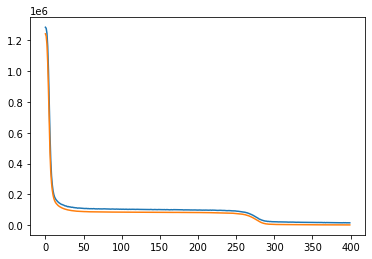

In [83]:
multi_train_loss, multi_test_loss = singal_train_CNN(11)

In [ ]:
TIME_LENGTH